# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

## Neural Network Model

Prompt:

```md
give me a tensorflow scaffolding that:
loads test, train, validate csvs from ./data
takes 7 features in a timeseries, with seasonality, across 12 months for 14 years
outputs a signal for an entire year
```

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt



DATA_PATH = "./data"



END_DATE = datetime(2022, 12, 31)


train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)


test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
test_df = test_df[test_df.index <= END_DATE]



print(f"Shapes: train_df: {train_df.shape} test_df: {test_df.shape}")
test_df

Shapes: train_df: (192, 10) test_df: (48, 10)


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k,tmin,tavg,tmax
Date,,,,,,,,,,
2019-01-01,0.44,224.76,46.96,10.45,63.06,14.190000,502.440833,8.8,11.60,14.40
2019-02-01,0.43,199.54,60.59,11.93,55.98,14.105000,504.060000,8.7,12.00,15.30
2019-03-01,0.39,199.28,58.86,16.83,55.91,14.020000,504.999167,11.2,14.50,17.70
2019-04-01,0.36,186.04,44.68,17.85,52.20,13.935000,505.938333,12.6,15.90,19.10
2019-05-01,0.33,189.43,34.20,21.52,53.15,13.850000,506.877500,14.3,18.30,22.30
2019-06-01,0.45,231.40,45.46,22.85,64.92,13.765000,507.816667,21.3,26.30,31.40
2019-07-01,0.50,278.55,82.34,23.40,78.15,13.680000,508.755833,23.2,27.50,32.60
2019-08-01,0.48,283.84,69.46,21.64,79.64,13.595000,509.695000,23.8,28.20,32.50
2019-09-01,0.43,238.35,68.75,18.01,66.87,13.510000,510.634167,22.0,25.60,29.10


Givens:
- This is a multivariate TS of pop, temp, demand, industry signals.
- Assume these are asynchronous, therefore noisy

Data DIM:
- 0: Sequences
- 1: Data in sequence
- 2: Features for that datum (AKA channels for COV1D)

In [2]:
FEATURES = [
    "Population_k",
    "tmax",
    "GDP_bln",
]
TARGET = "Plant_Production_GWh"
TIME_WINDOW = 12
LAGS = 1


def encode_lagged_timeseries(data_df, window=TIME_WINDOW, lag=LAGS):
    sequences, features = list(), list()
    for i in range(window, 0, -1):
        sequences.append(data_df.shift(i))
        features += [("%s(t-%d)" % (col, i)) for col in data_df.columns]

    sequences.append(data_df)
    features += [("%s(t)" % (col)) for col in data_df.columns]

    # the target label - next month if lag is 1
    sequences.append(data_df.shift(-lag))
    features += [("%s(t+%d)" % (col, lag)) for col in data_df.columns]

    ts_df = pd.concat(sequences, axis=1)
    ts_df.columns = features
    ts_df.dropna(inplace=True)

    return ts_df


X = encode_lagged_timeseries(train_df[FEATURES])
y = encode_lagged_timeseries(train_df[[TARGET]])
Xt = encode_lagged_timeseries(test_df[FEATURES])
yt = encode_lagged_timeseries(test_df[[TARGET]])

print(f"Train -> X Shape: {X.shape} y Shape: {y.shape} ")
print(f"Testt -> X Shape: {Xt.shape} y Shape: {yt.shape} ")
X.head(2)

Train -> X Shape: (179, 42) y Shape: (179, 14) 
Testt -> X Shape: (35, 42) y Shape: (35, 14) 


,Population_k(t-12),tmax(t-12),GDP_bln(t-12),Population_k(t-11),tmax(t-11),GDP_bln(t-11),Population_k(t-10),tmax(t-10),GDP_bln(t-10),Population_k(t-9),...,GDP_bln(t-2),Population_k(t-1),tmax(t-1),GDP_bln(t-1),Population_k(t),tmax(t),GDP_bln(t),Population_k(t+1),tmax(t+1),GDP_bln(t+1)
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,398.58,15.6,4.8200,398.580000,13.0,4.8275,398.804167,15.7,4.8350,399.028333,...,4.8950,400.821667,16.4,4.9025,401.045833,15.0,4.91,401.270000,16.3,4.93
2004-02-01,398.58,13.0,4.8275,398.804167,15.7,4.8350,399.028333,18.7,4.8425,399.252500,...,4.9025,401.045833,15.0,4.9100,401.270000,16.3,4.93,401.483333,16.6,4.95


In [3]:
X_series = X.values.reshape((X.shape[0], X.shape[1], 1))
Xt_series = Xt.values.reshape((Xt.shape[0], Xt.shape[1], 1))

y_series = y.values.reshape((y.shape[0], y.shape[1], 1))
yt_series = yt.values.reshape((yt.shape[0], yt.shape[1], 1))

print(f"Altered shapes: train: {X_series.shape} test: {Xt_series.shape}")

Altered shapes: train: (179, 42, 1) test: (35, 42, 1)


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Input, MaxPooling1D, Dropout, Dense

EPOCHS = 45  # converges around here
BATCH_SIZE = 32
FILTERS = [18, 4]
DROPRATE = 0.18
POOL_SIZE = 2
K_SIZE = 8

model = Sequential(
    [
        Input(shape=(Xt_series.shape[1], Xt_series.shape[2])),
        Conv1D(FILTERS[0], kernel_size=K_SIZE, activation="relu"),
        Conv1D(FILTERS[1], kernel_size=K_SIZE, activation="relu"),
        MaxPooling1D(pool_size=POOL_SIZE),  # DIM reduction by 2
        Flatten(),  # Vector dim reduction to 1
        Dropout(DROPRATE),  # this will lessen overfitting.
        Dense(1),  # univariate predicting next month
    ]
)


model.compile(optimizer="adam", loss="mse", run_eagerly=True)
history = model.fit(
    X_series,
    y_series,
    validation_data=(Xt_series, yt_series),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 35, 18)            162       
                                                                 
 conv1d_13 (Conv1D)          (None, 28, 4)             580       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 14, 4)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 56)                0         
                                                                 
 dropout_6 (Dropout)         (None, 56)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 57        
                                                      

2/2 [==============================] - 0s 13ms/step - loss: 1380.2010
Largest Error -> train: 26.35443209990672 test: 37.151057182867454


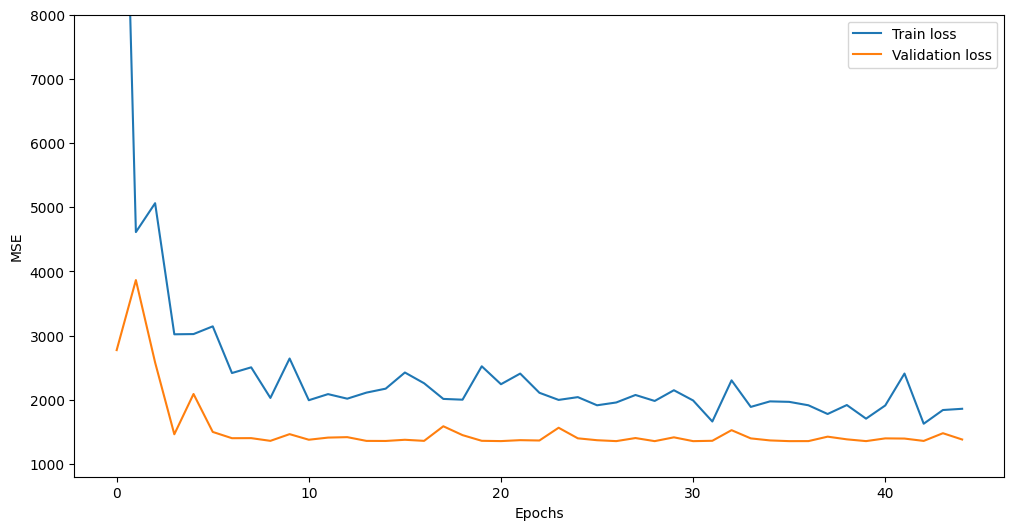

In [37]:
y_pred = model.predict(X_series)
yt_pred = model.predict(Xt_series)

loss = np.sqrt(model.evaluate(X_series, y_series))
t_loss = np.sqrt(model.evaluate(Xt_series, yt_series))

print(f"Largest Error -> train: {loss} test: {t_loss}")

plt.figure(figsize=(12, 6))
plt.ylim(bottom=800, top=8000)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()  # VGG16

In [38]:
yt_pred

array([[211.61723],
       [211.44534],
       [211.62114],
       [211.91205],
       [212.4134 ],
       [213.27414],
       [213.94057],
       [214.56099],
       [214.87776],
       [214.8726 ],
       [214.85013],
       [214.8536 ],
       [214.7789 ],
       [214.63045],
       [214.23083],
       [214.06395],
       [214.40256],
       [214.94675],
       [215.48268],
       [215.74432],
       [215.80403],
       [215.82922],
       [215.95868],
       [216.11588],
       [215.89458],
       [215.54892],
       [215.36122],
       [215.33456],
       [215.64566],
       [216.33556],
       [217.0125 ],
       [217.32974],
       [217.26921],
       [217.15936],
       [217.32356]], dtype=float32)

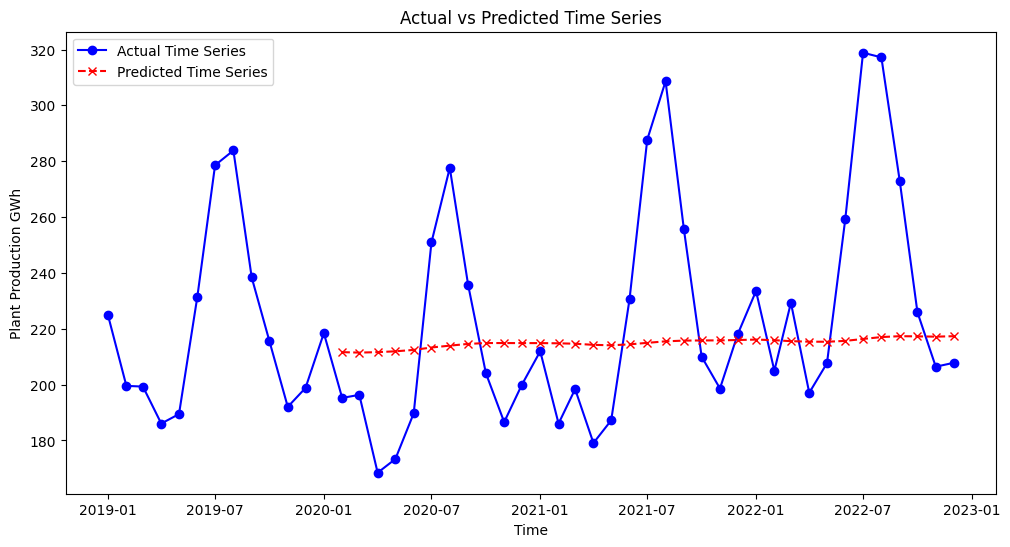

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(test_df[TARGET], label="Actual Time Series", color="blue", marker="o")

# we need i full year to predict the next month
plt.plot(
    test_df[TARGET].iloc[TIME_WINDOW + 1 :].index,
    yt_pred,
    label="Predicted Time Series",
    color="red",
    linestyle="dashed",
    marker="x",
)

plt.xlabel("Time")
plt.ylabel("Plant Production GWh")
plt.title("Actual vs Predicted Time Series")
plt.legend()
plt.show()